In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Configuration ---
# Base directory for all data
base_data_dir = r'D:\.Study\projects\EnergyForecasting\data' # Use r'...' for raw string

# NEW: Subdirectory where your new year-wise load files are located
raw_load_data_subdir = 'pjm_load_2022_2025'
raw_load_data_full_path = os.path.join(base_data_dir, raw_load_data_subdir)

# Directory to save the final processed file
processed_output_dir = os.path.join(base_data_dir, 'processed')

# List of zone abbreviations (uppercase, as used in your models and other processing)
# These will be used to find files (after converting to lowercase for filenames)
PJM_ZONES_UPPER = ['DOM', 'PN', 'PEPCO', 'AECO', 'PE'] # Matched to your description: aeco, dom, pe, pepco, pn

# NEW: Map uppercase zone identifiers to lowercase filenames if needed
# This handles 'PEPCO' -> 'pepco', 'AECO' -> 'aeco' for filenames
ZONE_FILENAME_MAP = {
    'DOM': 'dom',
    'PN': 'pn',
    'PEPCO': 'pepco', # Your files are 'pepco_YEAR.csv'
    'AECO': 'aeco',   # Your files are 'aeco_YEAR.csv'
    'PE': 'pe'
}

# NEW: Years of data you have
YEARS = [2022, 2023, 2024, 2025]
# For 2025, data is only until May 31st. This will be handled by the data itself.

# NEW: Output filename for the combined processed data
output_file_name_MULTIYEAR = 'pjm_hourly_load_multi_zone_cleaned_2022-2025May.csv'

# Key column names FROM YOUR NEW CSV FILES (VERIFY THESE!)
# I'm assuming 'datetime_beginning_utc' or a similar UTC timestamp column, and 'mw' for load.
# If your new files use different names, CHANGE THEM HERE.
# Example: If timestamp is 'HE', load is 'RT_LMP_DA_LMP', etc.
# For now, I'll assume a generic 'Timestamp' and 'Load' if not 'datetime_beginning_utc' and 'mw'.
# Please inspect your CSVs and update these!
TIMESTAMP_COL_NAME_IN_CSV = 'datetime_beginning_utc' # OR e.g., 'Timestamp', 'DATETIME_BEGINNING_EPT'
LOAD_VALUE_COL_NAME_IN_CSV = 'mw'                  # OR e.g., 'Load', 'MW'

# Does the CSV still contain a 'zone' column? If so, what's its name?
# If not, set to None or an empty string.
# This might not be needed if filenames dictate the zone.
ZONE_COL_NAME_IN_CSV = 'zone' # Or None, if not present. Will be used by process_single_df_data

print(f"Raw load data expected in: {raw_load_data_full_path}")
print(f"Processed output will be saved to: {processed_output_dir}")
print(f"Zones to process: {PJM_ZONES_UPPER}")
print(f"Years to process: {YEARS}")

Raw load data expected in: D:\.Study\projects\EnergyForecasting\data\pjm_load_2022_2025
Processed output will be saved to: D:\.Study\projects\EnergyForecasting\data\processed
Zones to process: ['DOM', 'PN', 'PEPCO', 'AECO', 'PE']
Years to process: [2022, 2023, 2024, 2025]


In [2]:
def parse_datetime_flexible(series):
    """
    Attempts to parse a datetime series with multiple potential formats.
    Handles common PJM formats including those with AM/PM.
    """
    # Try direct to_datetime first (handles many standard formats)
    parsed_series = pd.to_datetime(series, errors='coerce')
    
    # If many NaTs, try specific formats known to cause issues or be common
    # Example for 'mm/dd/yyyy hh:MM:SS AM/PM'
    # This format needs careful handling if mixed with 24-hour formats
    # For simplicity, pd.to_datetime with errors='coerce' is often robust enough.
    # If specific formats are consistently failing, add them here:
    # if parsed_series.isnull().sum() > len(series) * 0.5: # If more than 50% failed
    #     try_formats = ["%m/%d/%Y %I:%M:%S %p", "%m-%d-%Y %H:%M:%S"] # Add more as needed
    #     for fmt in try_formats:
    #         temp_parsed = pd.to_datetime(series, format=fmt, errors='coerce')
    #         if not temp_parsed.isnull().all(): # If this format worked for some
    #             parsed_series = parsed_series.fillna(temp_parsed) # Fill NaNs with newly parsed
    #             if parsed_series.isnull().sum() == 0: break

    return parsed_series

def process_zone_dataframe(df_input, zone_id_expected, ts_col, load_col, zone_col_in_csv_data=None):
    """
    Processes a DataFrame for a single PJM zone (potentially from multiple concatenated files).
    - Sets datetime index.
    - Handles duplicate timestamps by averaging for specified zones (PEPCO, AECO).
    - Selects and renames the load column.
    - Fills missing values.
    
    Args:
        df_input (pd.DataFrame): The input DataFrame for a single zone.
        zone_id_expected (str): The UPPERCASE zone identifier (e.g., 'PEPCO').
        ts_col (str): Name of the timestamp column in df_input.
        load_col (str): Name of the load column in df_input.
        zone_col_in_csv_data (str, optional): Name of a column in df_input that might contain zone info.
                                            Used for an optional sanity check.
    """
    print(f"  Processing DataFrame for zone '{zone_id_expected}'. Initial shape: {df_input.shape}")
    df = df_input.copy()

    # 1. Verify Zone (optional sanity check if zone_col_in_csv_data is provided and exists)
    if zone_col_in_csv_data and zone_col_in_csv_data in df.columns:
        unique_zones_in_file = df[zone_col_in_csv_data].unique()
        # Allow for multiple forms (e.g. 'PEPCO' and 'Pepco') by converting to upper/lower for check
        # Or check if zone_id_expected (uppercase) is among the unique_zones (after they are uppercased)
        if not any(str(z).upper() == zone_id_expected for z in unique_zones_in_file):
            print(f"  WARNING: Expected zone '{zone_id_expected}' but found {unique_zones_in_file} in column '{zone_col_in_csv_data}'.")
        else:
            print(f"  Confirmed zone related to '{zone_id_expected}' found in column '{zone_col_in_csv_data}'.")
    
    # 2. Handle Timestamps
    if ts_col not in df.columns:
        print(f"  ERROR: Timestamp column '{ts_col}' not found. Columns are: {df.columns.tolist()}. Skipping zone.")
        return None
    
    # Use the flexible parser
    df[ts_col] = parse_datetime_flexible(df[ts_col])
    
    if df[ts_col].isnull().all():
        print(f"  ERROR: All timestamps are NaT after parsing for column '{ts_col}'. Check formats. Skipping zone.")
        return None
    df.dropna(subset=[ts_col], inplace=True)
    if df.empty:
        print(f"  ERROR: DataFrame empty after dropping NaT timestamps. Skipping zone.")
        return None
        
    df.set_index(ts_col, inplace=True)
    df.sort_index(inplace=True) # Important after concatenating multiple years
    print(f"  Set '{ts_col}' as DatetimeIndex and sorted.")

    # 3. Convert load column to numeric
    if load_col not in df.columns:
        print(f"  ERROR: Load column '{load_col}' not found. Columns are: {df.columns.tolist()}. Skipping zone.")
        return None
    df[load_col] = pd.to_numeric(df[load_col], errors='coerce')
    print(f"  Converted '{load_col}' to numeric. Missing after conversion: {df[load_col].isnull().sum()}")
    df.dropna(subset=[load_col], inplace=True) # Drop rows where load is non-numeric
    if df.empty:
        print(f"  ERROR: DataFrame empty after dropping non-numeric load values. Skipping zone.")
        return None

    # 4. Handle potential duplicate timestamps
    # Use uppercase zone_id_expected for this check
    processed_zone_load_col_name = f"{zone_id_expected}_Load"

    # PJM zones often having duplicate DST transition hour labels are PEPCO and AECO (formerly AE)
    # Adjust this list based on your specific knowledge of the zones.
    zones_with_potential_duplicates = ['PEPCO', 'AECO'] 

    if zone_id_expected.upper() in zones_with_potential_duplicates:
        print(f"  Zone {zone_id_expected} identified for potential duplicate timestamp averaging.")
        if df.index.has_duplicates:
            print(f"  Found {df.index.duplicated().sum()} duplicate timestamps in {zone_id_expected}. Averaging ONLY the '{load_col}' column.")
            # Group by index and average the load column. Select only the load column before grouping.
            averaged_load_series = df[load_col].groupby(df.index).mean()
            zone_df_final = averaged_load_series.to_frame(name=processed_zone_load_col_name)
            print(f"  Averaged '{load_col}'. New shape for {zone_id_expected}: {zone_df_final.shape}")
        else:
            print(f"  No duplicate timestamps found in {zone_id_expected} (index was already unique). Selecting '{load_col}'.")
            zone_df_final = df[[load_col]].copy()
            zone_df_final.rename(columns={load_col: processed_zone_load_col_name}, inplace=True)
    else:
        # For zones without expected duplicates, ensure index is unique. If not, warn and take first.
        if df.index.has_duplicates:
            print(f"  WARNING: Zone {zone_id_expected} not in explicit duplicate handling list, but has {df.index.duplicated().sum()} duplicate timestamps. Keeping first entry for duplicates.")
            df = df[~df.index.duplicated(keep='first')]
        zone_df_final = df[[load_col]].copy()
        zone_df_final.rename(columns={load_col: processed_zone_load_col_name}, inplace=True)
    
    print(f"  Selected/processed load column, renamed to '{processed_zone_load_col_name}'.")
    
    # 5. Handle Missing Values (ffill and bfill)
    missing_before = zone_df_final[processed_zone_load_col_name].isnull().sum()
    if missing_before > 0:
        print(f"  Missing values in '{processed_zone_load_col_name}' before fill: {missing_before}")
    
    zone_df_final[processed_zone_load_col_name] = zone_df_final[processed_zone_load_col_name].ffill()
    zone_df_final[processed_zone_load_col_name] = zone_df_final[processed_zone_load_col_name].bfill()
    
    missing_after = zone_df_final[processed_zone_load_col_name].isnull().sum()
    if missing_after > 0:
        print(f"  Missing values in '{processed_zone_load_col_name}' after fill: {missing_after}")
    elif missing_before > 0 : # Only print if there were missings before
        print(f"  All missing values in '{processed_zone_load_col_name}' filled.")


    if zone_df_final[processed_zone_load_col_name].isnull().all():
        print(f"  ERROR: Entire column '{processed_zone_load_col_name}' is NaN after processing. Skipping zone.")
        return None

    # Ensure the DataFrame is not empty before returning
    if zone_df_final.empty:
        print(f"  ERROR: DataFrame for zone {zone_id_expected} became empty during processing. Skipping.")
        return None
        
    return zone_df_final

In [3]:
all_zone_processed_dfs_multiyear = [] # Stores the final DF for each zone (all its years combined)

print("--- Starting Processing of All Zone Files (Multi-Year) ---")

for zone_upper in PJM_ZONES_UPPER: # e.g., 'PEPCO'
    zone_filename_lower = ZONE_FILENAME_MAP.get(zone_upper) # e.g., 'pepco'
    if not zone_filename_lower:
        print(f"Skipping zone {zone_upper} as it's not in ZONE_FILENAME_MAP.")
        continue

    print(f"\nProcessing all years for Zone: {zone_upper} (using file prefix: {zone_filename_lower})")
    
    yearly_dfs_for_this_zone = [] # To store DataFrames for 2022, 2023, etc. for *this* zone
    
    for year in YEARS:
        # Construct filename, e.g., pepco_2023.csv
        current_file_name = f"{zone_filename_lower}_{year}.csv"
        current_file_path = os.path.join(raw_load_data_full_path, current_file_name)
        
        print(f"  Attempting to load file: {current_file_path}")
        if os.path.exists(current_file_path):
            try:
                # Read the CSV for this specific year and zone
                # Add encoding='utf-8' or 'latin1' if you encounter UnicodeDecodeError
                df_year_zone = pd.read_csv(current_file_path)
                print(f"    Successfully loaded {current_file_name}. Shape: {df_year_zone.shape}")
                yearly_dfs_for_this_zone.append(df_year_zone)
            except Exception as e:
                print(f"    ERROR loading or initially processing {current_file_name}: {e}")
        else:
            print(f"    File not found: {current_file_name}")

    if not yearly_dfs_for_this_zone:
        print(f"  No data files found or loaded for zone {zone_upper}. Skipping this zone.")
        continue
        
    # Concatenate all yearly DataFrames for the current zone
    combined_df_for_this_zone = pd.concat(yearly_dfs_for_this_zone, ignore_index=True)
    print(f"  Concatenated all yearly data for {zone_upper}. Total rows: {len(combined_df_for_this_zone)}")
    
    # Process the combined DataFrame for this zone
    # Pass the uppercase zone identifier for naming consistency and checks
    processed_df_single_zone = process_zone_dataframe(
        df_input=combined_df_for_this_zone,
        zone_id_expected=zone_upper, # Pass the uppercase 'PEPCO', 'AECO' etc.
        ts_col=TIMESTAMP_COL_NAME_IN_CSV,
        load_col=LOAD_VALUE_COL_NAME_IN_CSV,
        zone_col_in_csv_data=ZONE_COL_NAME_IN_CSV # Optional, based on your CSV content
    )
    
    if processed_df_single_zone is not None and not processed_df_single_zone.empty:
        all_zone_processed_dfs_multiyear.append(processed_df_single_zone)
        print(f"  Successfully processed and added data for zone {zone_upper}.")
    else:
        print(f"  Skipping zone {zone_upper} for final combination due to processing errors or empty result from process_zone_dataframe.")

print("\n--- Finished processing individual zone multi-year data ---")
print(f"Successfully prepared data for {len(all_zone_processed_dfs_multiyear)} out of {len(PJM_ZONES_UPPER)} zones.")

--- Starting Processing of All Zone Files (Multi-Year) ---

Processing all years for Zone: DOM (using file prefix: dom)
  Attempting to load file: D:\.Study\projects\EnergyForecasting\data\pjm_load_2022_2025\dom_2022.csv
    Successfully loaded dom_2022.csv. Shape: (8760, 8)
  Attempting to load file: D:\.Study\projects\EnergyForecasting\data\pjm_load_2022_2025\dom_2023.csv
    Successfully loaded dom_2023.csv. Shape: (8760, 8)
  Attempting to load file: D:\.Study\projects\EnergyForecasting\data\pjm_load_2022_2025\dom_2024.csv
    Successfully loaded dom_2024.csv. Shape: (8784, 8)
  Attempting to load file: D:\.Study\projects\EnergyForecasting\data\pjm_load_2022_2025\dom_2025.csv
    Successfully loaded dom_2025.csv. Shape: (3575, 8)
  Concatenated all yearly data for DOM. Total rows: 29879
  Processing DataFrame for zone 'DOM'. Initial shape: (29879, 8)
  Confirmed zone related to 'DOM' found in column 'zone'.
  Set 'datetime_beginning_utc' as DatetimeIndex and sorted.
  Converted 'mw

In [4]:
combined_load_df_final = pd.DataFrame()

if not all_zone_processed_dfs_multiyear:
    print("No zone DataFrames were successfully processed and combined across years. Cannot create final DataFrame.")
elif len(all_zone_processed_dfs_multiyear) == 1:
    print("Only one zone's multi-year data processed. Using it as the final combined DataFrame.")
    combined_load_df_final = all_zone_processed_dfs_multiyear[0]
else:
    print("\n--- Combining all processed multi-year zone DataFrames ---")
    # Start with the first DataFrame as the base for merging
    combined_load_df_final = all_zone_processed_dfs_multiyear[0].copy()
    
    for i in range(1, len(all_zone_processed_dfs_multiyear)):
        next_df_to_merge = all_zone_processed_dfs_multiyear[i]
        if not next_df_to_merge.empty:
            print(f"Merging with DataFrame for zone: {next_df_to_merge.columns[0]}")
            combined_load_df_final = pd.merge(combined_load_df_final, next_df_to_merge,
                                            left_index=True, right_index=True,
                                            how='outer') # 'outer' keeps all timestamps
        else:
            print(f"Skipping an empty DataFrame at index {i} during final merge.")
            
    if not combined_load_df_final.empty:
        print("Successfully merged all zone DataFrames.")
    else:
        print("ERROR: Final combined DataFrame is empty after merging steps.")


if not combined_load_df_final.empty:
    print(f"\nFinal Combined Load DataFrame has {len(combined_load_df_final)} rows.")
    print("Shape:", combined_load_df_final.shape)
    print("\nFinal Combined Load DataFrame (first 3 rows):")
    print(combined_load_df_final.head(3))
    print("\nFinal Combined Load DataFrame (last 3 rows):")
    print(combined_load_df_final.tail(3))
    print("\nInformation about Final Combined Load DataFrame:")
    combined_load_df_final.info()

    # Final check for NaNs after outer merge
    # This can happen if zones have different start/end dates across the full multi-year range.
    # For load data, it's often better to ensure all zones cover a common range,
    # or handle NaNs very carefully (e.g., interpolate if appropriate, or drop incomplete start/end periods).
    # For now, standard ffill/bfill.
    print("\nMissing values in final_combined_df BEFORE final fill:")
    print(combined_load_df_final.isnull().sum()[combined_load_df_final.isnull().sum() > 0]) # Show only cols with NaNs

    combined_load_df_final.ffill(inplace=True)
    combined_load_df_final.bfill(inplace=True)
    
    print("\nMissing values in final_combined_df AFTER final fill:")
    remaining_nans = combined_load_df_final.isnull().sum().sum()
    if remaining_nans > 0:
        print(combined_load_df_final.isnull().sum()[combined_load_df_final.isnull().sum() > 0])
    else:
        print("No NaNs remaining after fill.")

    if combined_load_df_final.isnull().all().any():
        print("CRITICAL WARNING: One or more columns in the final combined DataFrame are entirely NaN!")
    
    # Sort index one last time after all merges and fills
    combined_load_df_final.sort_index(inplace=True)
    print("\nFinal DataFrame index sorted.")

    # Check for duplicate indices in the final combined DataFrame (should have been handled per zone)
    if combined_load_df_final.index.has_duplicates:
        print("\nWARNING: The FINAL combined_load_df has DUPLICATE TIMESTAMPS in its index! This should not happen if per-zone processing was correct.")
        duplicate_counts = combined_load_df_final.index.value_counts()
        print(duplicate_counts[duplicate_counts > 1].head())
    else:
        print("\nConfirmed: The FINAL combined_load_df has a unique DatetimeIndex.")
else:
    print("Final combined load DataFrame is empty. Check processing steps for errors.")


--- Combining all processed multi-year zone DataFrames ---
Merging with DataFrame for zone: PN_Load
Merging with DataFrame for zone: PEPCO_Load
Merging with DataFrame for zone: AECO_Load
Merging with DataFrame for zone: PE_Load
Successfully merged all zone DataFrames.

Final Combined Load DataFrame has 29879 rows.
Shape: (29879, 5)

Final Combined Load DataFrame (first 3 rows):
                        DOM_Load   PN_Load  PEPCO_Load  AECO_Load   PE_Load
datetime_beginning_utc                                                     
2022-01-01 05:00:00     9879.540  1517.266    2169.749    871.977  3490.865
2022-01-01 06:00:00     9549.307  1462.484    2065.314    834.028  3352.814
2022-01-01 07:00:00     9346.150  1434.579    2013.883    796.671  3224.528

Final Combined Load DataFrame (last 3 rows):
                         DOM_Load   PN_Load  PEPCO_Load  AECO_Load   PE_Load
datetime_beginning_utc                                                      
2025-05-30 01:00:00     14759.984  181

In [5]:
if not combined_load_df_final.empty:
    if not os.path.exists(processed_output_dir):
        os.makedirs(processed_output_dir)
        print(f"Created directory: {processed_output_dir}")

    # Use the new output filename defined in Cell 1
    final_output_path = os.path.join(processed_output_dir, output_file_name_MULTIYEAR)
    
    combined_load_df_final.to_csv(final_output_path)
    print(f"\nProcessed and combined multi-year load data saved to: {final_output_path}")
else:
    print("\nFinal combined load DataFrame is empty. Nothing to save.")


Processed and combined multi-year load data saved to: D:\.Study\projects\EnergyForecasting\data\processed\pjm_hourly_load_multi_zone_cleaned_2022-2025May.csv



--- Plotting Combined Multi-Year Load Data ---


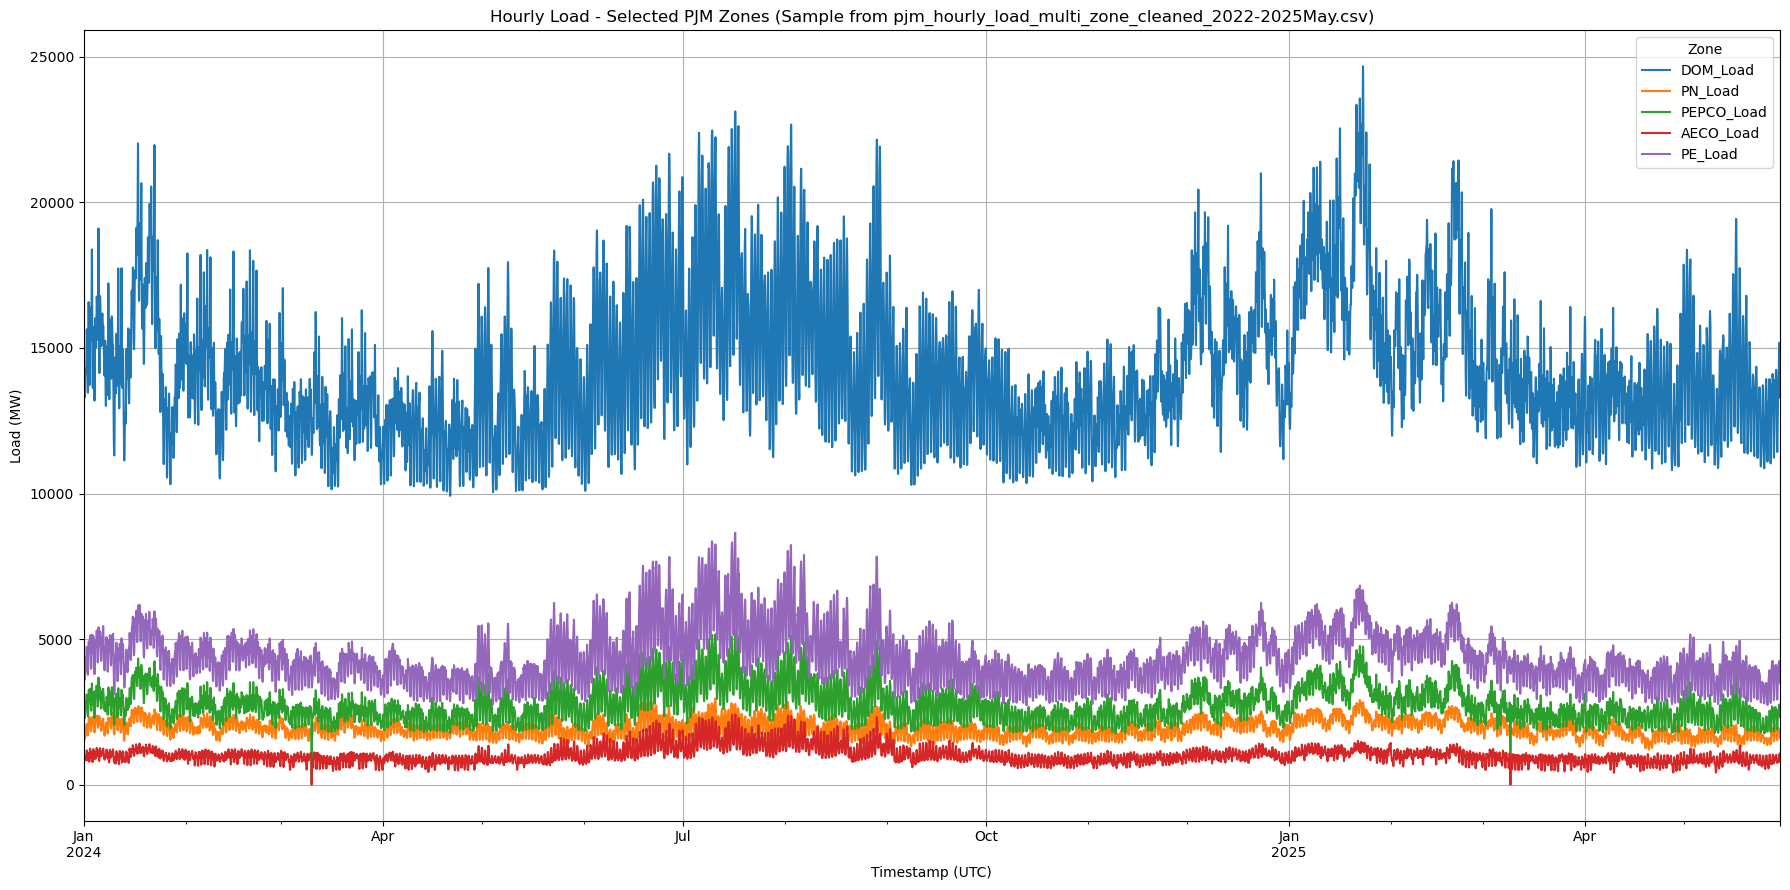


Plotting sample period data (745 points)...


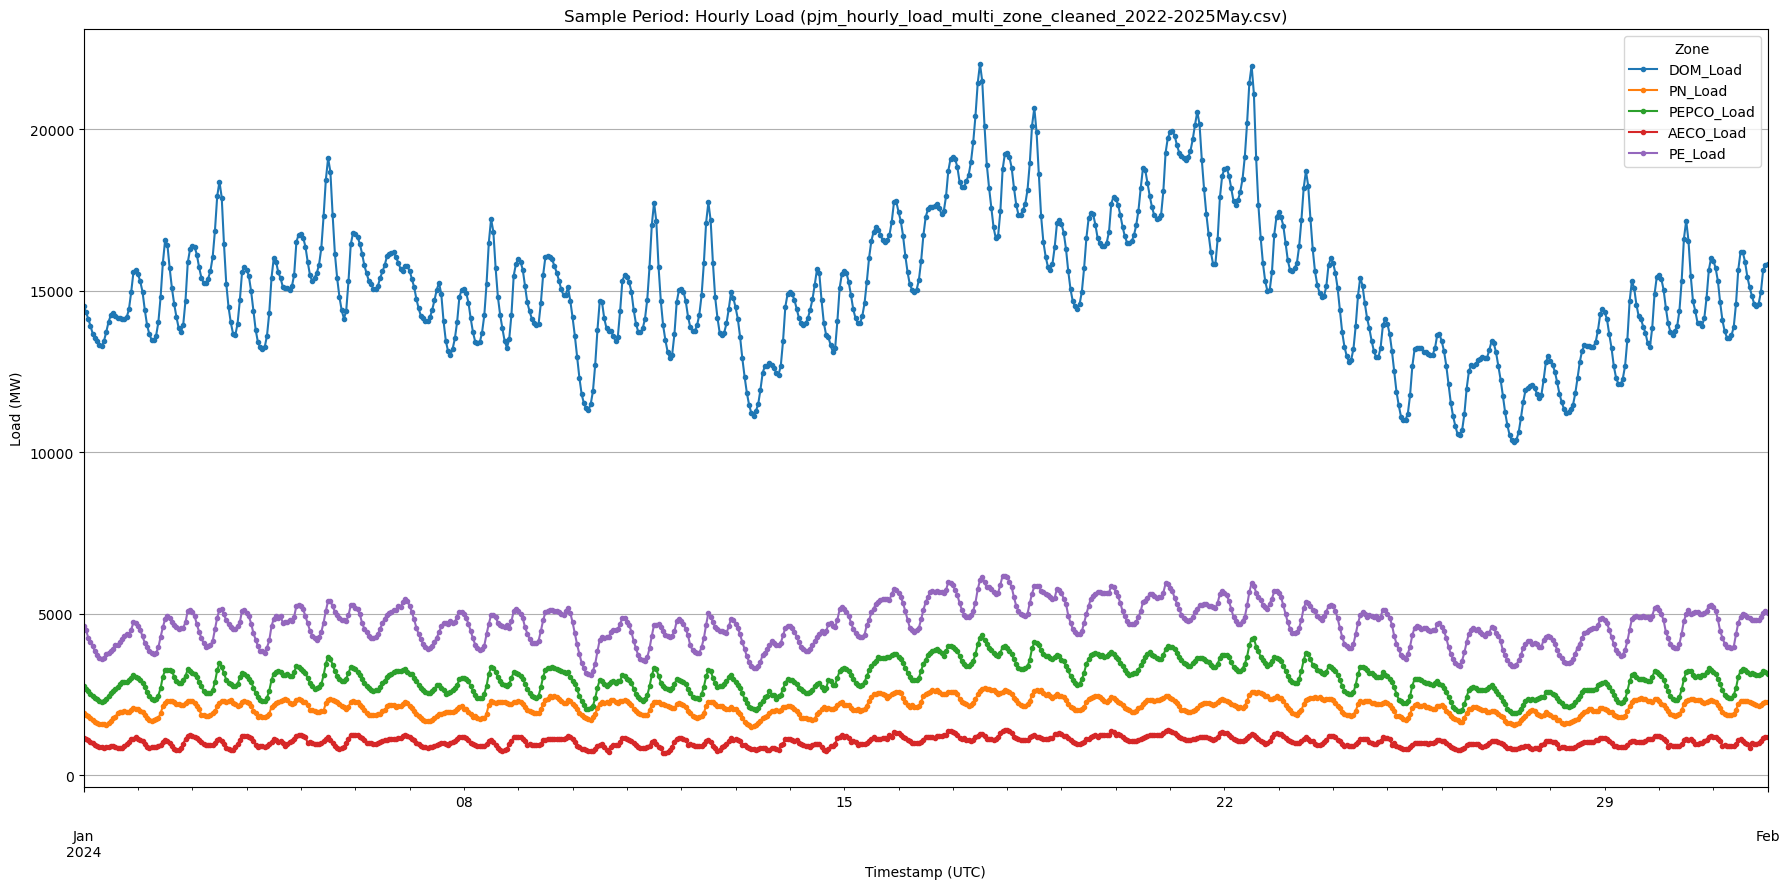

In [6]:
if not combined_load_df_final.empty:
    print("\n--- Plotting Combined Multi-Year Load Data ---")
    
    numeric_cols = combined_load_df_final.select_dtypes(include=np.number).columns
    if not combined_load_df_final[numeric_cols].empty:
        # Plot a sample, e.g., the last year of data, or a specific year, to avoid overly dense plots
        # For example, plot data from 2024 onwards if available
        plot_start_date = pd.to_datetime("2024-01-01")
        data_to_plot = combined_load_df_final[combined_load_df_final.index >= plot_start_date]
        
        if data_to_plot.empty:
            print("No data from 2024 onwards to plot, plotting all available data (might be dense).")
            data_to_plot = combined_load_df_final

        data_to_plot[numeric_cols].plot(figsize=(18, 9), subplots=False)
        plt.title(f'Hourly Load - Selected PJM Zones (Sample from {output_file_name_MULTIYEAR})')
        plt.xlabel('Timestamp (UTC)')
        plt.ylabel('Load (MW)')
        plt.legend(title='Zone')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plotting a shorter period like the first month of the last available full year
        if len(combined_load_df_final) > 24*30 : # Check if there's at least a month of data
            # Try to get the start of the last full year available in the data
            last_year_in_data = combined_load_df_final.index.max().year
            first_month_last_year_start = pd.to_datetime(f"{last_year_in_data-1}-01-01") # Example: if max is 2025, try 2024
            if combined_load_df_final.index.min().year < last_year_in_data: # if data before last year exists
                 first_month_last_year_end = first_month_last_year_start + pd.DateOffset(months=1)
                 sample_period_data = combined_load_df_final.loc[first_month_last_year_start:first_month_last_year_end]
            else: # Fallback to last 30 days
                 sample_period_data = combined_load_df_final.iloc[-24*30:]


            if not sample_period_data.empty:
                print(f"\nPlotting sample period data ({len(sample_period_data)} points)...")
                sample_period_data[numeric_cols].plot(figsize=(18, 9), marker='.', linestyle='-')
                plt.title(f'Sample Period: Hourly Load ({output_file_name_MULTIYEAR})')
                plt.xlabel('Timestamp (UTC)')
                plt.ylabel('Load (MW)')
                plt.legend(title='Zone')
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print("Not enough data for sample period plot.")
    else:
        print("No numeric columns found in the final DataFrame to plot.")
else:
    print("Cannot plot, final combined_load_df is empty.")